# Trends

Look at trends in taxi/rideshare use over the last few rounds of the NHTS.

Author: Matthew Wigginton Conway <matt@indicatrix.org>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import partial
from matplotlib.ticker import FuncFormatter
from nhts import estReplicateSE, multiReplicateSE
import textwrap

In [2]:
TAXI_COLOR = '#77bb77'
GENERAL_COLOR = '#aaaaff'

## Define weighting variables

The weight variables have slightly different names over the years. The travel day weights are a simple function of the person weights, so use person weights for everything. This is valid, since all travel day variables we examine are used in proportions.

In [3]:
WEIGHTS = {
    1995: 'WTPERFIN',
    2001: 'WTPERFIN',
    2009: 'WTPERFIN',
    2017: 'WTPERFIN'
}

REP_WEIGHTS = {
    1995: 'WTPERFIN',
    2001: 'WTPFIN', # were they paying by the letter?
    2009: 'WTPERFIN',
    2017: 'WTPERFIN'
}

## Define a function to parse the fixed-width 1995 NHTS files

The 1995 NHTS uses fixed-width files with separate schemas. The function below parses such files, using schemas converted to CSV format through importing to Excel and making a few manual tweaks.

In [4]:
def parseNhtsFixedWidth (filename, schemaname):
    schema = pd.read_csv(schemaname)
    # Convert from 1-based indexing to 0-based. No need to do at end because end in schema file is inclusive, while
    # pandas expects an exclusive end
    if 'Start' in schema.columns:
        colspecs = schema.apply(lambda x: (x.Start - 1, x.End), 1).values.tolist()
        data = pd.read_fwf(filename, colspecs=colspecs, names=schema['Field Name'])
    else:
        data = pd.read_fwf(filename, widths=schema.Width, names=schema['Field Name'])
    return data

## Read data

We have data from the 1983, 1990, and 1995 NPTS and the 2001, 2009 and 2017 NHTS. It turns out though that the 1983 and 1990 weren't very useful. All years since 2001 have replicate weights for standard error estimation, which are provided in separate files, so we pull those in as well and join them.

In [5]:
trips17 = pd.read_csv('../data/2017/trippub.csv')
repl17 = pd.read_csv('../data/2017/perwgt.csv')
trips17 = trips17.merge(repl17.drop(['WTTRDFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')
pers17 = pd.read_csv('../data/2017/perpub.csv')
pers17 = pers17.merge(repl17.drop(['WTPERFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')

In [6]:
trips09 = pd.read_csv('../data/2009/Ascii/DAYV2PUB.CSV')
repl09 = pd.read_csv('../data/2009/per50wt.csv')
trips09 = trips09.merge(repl09, on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')
pers09 = pd.read_csv('../data/2009/Ascii/PERV2PUB.CSV')
pers09 = pers09.merge(repl09.drop(['WTPERFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')

In [7]:
trips01 = pd.read_csv('../data/2001/DAYPUB.csv', low_memory=False)
repl01 = pd.read_csv('../data/2001/pr50wt.csv', low_memory=False)
trips01 = trips01.merge(repl01.drop(['WTTRDFIN'], 1), left_on=['HOUSEID', 'PERSONID'], right_on=['ID9', 'PERSONID'],
                        how='left', validate='m:1')
pers01 = pd.read_csv('../data/2001/PERPUB.CSV', low_memory=False)
pers01 = pers01.merge(repl01.drop(['WTPERFIN'], 1), left_on=['HOUSEID', 'PERSONID'], right_on=['ID9', 'PERSONID'],
                        how='left', validate='m:1')

In [8]:
trips95 = parseNhtsFixedWidth('../data/1995/dtrp95_2.txt', '../data/1995/dtrp95_2_schema.csv')
seg95 = parseNhtsFixedWidth('../data/1995/Segtrp95.txt', '../data/1995/Segtrp95_schema.csv')
pers95 = parseNhtsFixedWidth('../data/1995/PERS95_2.TXT', '../data/1995/PERS95_2_schema.csv')
trips95 = trips95.merge(pers95[['HOUSEID', 'PERSONID', 'WTPERFIN']], on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')
pers95 = pers95.drop(index=[95360]) # there's a blank line at the end of the file
trips95 = trips95.drop(index=[409025]) # same

### Confirm that person and travel day weights are interchangeable when calculating proportions

We use person weights everywhere, which are according to the documentation always 1/365 of the trip weights. Confirm this to be true.

In [9]:
# Confirm that person and travel day weights are interchangeable when calculating proportions
assert np.all(np.abs(trips17.WTTRDFIN / trips17.WTPERFIN - 365) < 1e-6)
assert np.all(np.abs(trips09.WTTRDFIN / trips09.WTPERFIN - 365) < 1e-6)
assert np.all(np.abs(trips01.WTTRDFIN / trips01.WTPERFIN - 365) < 1e-6)
# less precise on this one, they rounded all weights to two decimal places (I guess storage was in short supply back then...)
assert np.all(np.abs(trips95.WTTRDFIN / trips95.WTPERFIN - 365) < 15)

## Identify taxi users

Add a 'taxi' flag to each person who used a taxi on the travel day in each year of the NHTS.

In [10]:
def addTaxiVar (trips, persons, taxiModeCode):
    didUseTaxi = trips.groupby(['HOUSEID', 'PERSONID'], as_index=False)\
        .TRPTRANS.agg(lambda x: np.any(x.isin(taxiModeCode)))
    didUseTaxi.rename(columns={'TRPTRANS': 'taxi'}, inplace=True)
    persons = persons.merge(didUseTaxi, on=['HOUSEID', 'PERSONID'], how='left', validate='1:1')

    # Handle zero-trip-makers
    persons.taxi.fillna(False, inplace=True)
    
    return persons

In [11]:
# The Taxi mode for each year
TAXI_MODE = {
    2017: [17],
    2009: [19],
    2001: [22, 23], # 2001 has a separate Limousine mode. No other years do.
    1995: [15]
}

In [12]:
pers17 = addTaxiVar(trips17, pers17, TAXI_MODE[2017])
np.sum(pers17[pers17.taxi].WTPERFIN) / np.sum(pers17.WTPERFIN)

0.00937264449155716

In [13]:
pers09 = addTaxiVar(trips09, pers09, TAXI_MODE[2009])
np.sum(pers09[pers09.taxi].WTPERFIN) / np.sum(pers09.WTPERFIN)

0.004324943852378159

In [14]:
pers01 = addTaxiVar(trips01, pers01, TAXI_MODE[2001])
np.sum(pers01[pers01.taxi].WTPERFIN) / np.sum(pers01.WTPERFIN)

0.003946041465315296

In [15]:
pers95 = addTaxiVar(trips95, pers95, TAXI_MODE[1995])
np.sum(pers95[pers95.taxi].WTPERFIN) / np.sum(pers95.WTPERFIN)

0.004754340262795572

We can't use 1990 or 1983 because their taxi mode was only for commercial/business use.

<img src="whynot1990.png" />


<img src="whynot1983.png" />

## Trends in taxi use

Make a graph of the percentage of Americans using a taxi on any given day during different waves of the NHTS.

### First, define a function to compute standard errors

Each wave of the NHTS uses the same functional form for the replicate SE estimation, with different parameters. 2001 is, with x indicating the full-sample-weight estimate and $REP_i$ indicating the estimate using replicate weight i.

$$\sqrt{\frac{98}{99}\sum_{i=1}^{99}(REP_i - x)^2}.$$

For 2009 it is ([users guide, page 7-1](https://nhts.ornl.gov/2009/pub/UsersGuideV2.pdf))

$$\sqrt{\frac{99}{100}\sum_{i=1}^{100}(REP_i - x)^2}$$

and for 2017, after some algebraic manipulation, is

$$\sqrt{\frac{6}{7}\sum_{i=1}^{98}(REP_i - x)^2}.$$

These formulae are clearly all the same, with different fractional scalars and number of replicate weights. We can generalize the function to

$$\sqrt{a\sum_{i=1}^n(REP_i - x)^2},$$

where a is a scale factor and n is the number of replications. Then we can use the same function to estimate standard errors for all years.

`estReplicateSE` takes an estimator function that should take the replicate number as an argument and return an estimate using those replicate weights. The second argument is the point estimate using the full weights. You can then specify a keyword argument for year of the NHTS, or a _n_ and and a `scaleFactor`.

The 1995 NPTS does not include replicate weights. Appendix G of [the user's guide](https://nhts.ornl.gov/1995/Doc/UserGuide.pdf) describes how to compute standard errors with Taylor series linearizations, but [this post](https://www.r-bloggers.com/analyze-the-national-household-travel-survey-nhts-with-r-and-monetdb/) suggests that this is not accurate or advisable. Stata [seems to have commands to do this](https://www.stata.com/manuals13/svy.pdf) if I don't want to code them myself. However, 1995 was a long time ago, and not super relevant for much besides to show that the trends have been relatively flat, so rather than have two different ways to estimate standard errors for different waves of the survey, it seems fine to just leave the error bars off the very oldest data.

The two functions used for computing replicate standard errors have been moved to `nhts.py` to allow them to be shared between notebooks. The function below is a special-purpose function returning formatted TeX code for making tables.

## Define a function to print table values

When generating a table of proportions, this function returns LaTeX formatted point estimates of the proportion of restrictedSample in full sample. For example, if restrictedSample is all taxi users, and fullSample is all respondents, will compute the percentage of people who used a for hire vehicle on the travel day.

In [16]:
# Compute the point estimate and standard error for the proportion of the full sample in the restricted sample
# e.g. the proportion of taxi users less than 30.
def computeValueAndSE (restrictedSample, fullSample, year, includeCount=False):
    if len(restrictedSample) == 0:
        return '$0\%$'
    est = np.sum(restrictedSample[WEIGHTS[year]]) / np.sum(fullSample[WEIGHTS[year]])
    se = estReplicateSE(
        lambda i: np.sum(restrictedSample[f'{REP_WEIGHTS[year]}{i}']) / np.sum(fullSample[f'{REP_WEIGHTS[year]}{i}']),
        est,
        year
    )
    return f'${est * 100:.2f}\\% \\pm {se * 1.96 * 100:.2f}$' + (f' ({len(restrictedSample)})' if includeCount else '')


## Compute the mode share of for-hire vehicles over time

As expected, it shot up when Uber and Lyft were introduced.

Note that this is based on raw trips, with no deduplication, so it finds the mode share of _person-trips_. I.e. if I split a ridehail trip with someone else,  that would be two person-trips. Similarly, if I carpooled, or rode a tandem bicycle.

In [17]:
modeshare = pd.DataFrame(dict(proportion=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])

modeshare.loc[2017, 'proportion'] = np.sum(trips17[trips17.TRPTRANS.isin(TAXI_MODE[2017])][WEIGHTS[2017]]) / np.sum(trips17[WEIGHTS[2017]])
modeshare.loc[2017, 'se'] = estReplicateSE(
    lambda i: np.sum(trips17[trips17.TRPTRANS.isin(TAXI_MODE[2017])][f'{REP_WEIGHTS[2017]}{i}']) / np.sum(trips17[f'{REP_WEIGHTS[2017]}{i}']),
    modeshare.loc[2017, 'proportion'],
    year=2017
)

modeshare.loc[2009, 'proportion'] = np.sum(trips09[trips09.TRPTRANS.isin(TAXI_MODE[2009])][WEIGHTS[2009]]) / np.sum(trips09[WEIGHTS[2009]])
modeshare.loc[2009, 'se'] = estReplicateSE(
    lambda i: np.sum(trips09[trips09.TRPTRANS.isin(TAXI_MODE[2009])][f'{REP_WEIGHTS[2009]}{i}']) / np.sum(trips09[f'{REP_WEIGHTS[2009]}{i}']),
    modeshare.loc[2009, 'proportion'],
    year=2009
)

modeshare.loc[2001, 'proportion'] = np.sum(trips01[trips01.TRPTRANS.isin(TAXI_MODE[2001])][WEIGHTS[2001]]) / np.sum(trips01[WEIGHTS[2001]])
modeshare.loc[2001, 'se'] = estReplicateSE(
    lambda i: np.sum(trips01[trips01.TRPTRANS.isin(TAXI_MODE[2001])][f'{REP_WEIGHTS[2001]}{i}']) / np.sum(trips01[f'{REP_WEIGHTS[2001]}{i}']),
    modeshare.loc[2001, 'proportion'],
    year=2001
)

modeshare.loc[1995, 'proportion'] = np.sum(trips95[trips95.TRPTRANS.isin(TAXI_MODE[1995])][WEIGHTS[1995]]) / np.sum(trips95[WEIGHTS[1995]])
modeshare.loc[1995, 'se'] = np.nan

#### Look at the percent of the population that used a for-hire vehicle on a particular day

We expect for-hire vehicles to be a marginal mode; most people who use them don't likely use them exclusively. Let's compute the percentage of people who took at least one for-hire vehicle trip on the travel day.

In [18]:
percent = pd.DataFrame(dict(proportion=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])

percent.loc[2017, 'proportion'] = np.sum(pers17[pers17.taxi][WEIGHTS[2017]]) / np.sum(pers17[WEIGHTS[2017]])
percent.loc[2017, 'se'] = estReplicateSE(
    lambda i: np.sum(pers17[pers17.taxi][f'{REP_WEIGHTS[2017]}{i}']) / np.sum(pers17[f'{REP_WEIGHTS[2017]}{i}']),
    percent.loc[2017, 'proportion'],
    year=2017
)

percent.loc[2009, 'proportion'] = np.sum(pers09[pers09.taxi][WEIGHTS[2009]]) / np.sum(pers09[WEIGHTS[2009]])
percent.loc[2009, 'se'] = estReplicateSE(
    lambda i: np.sum(pers09[pers09.taxi][f'{REP_WEIGHTS[2009]}{i}']) / np.sum(pers09[f'{REP_WEIGHTS[2009]}{i}']),
    percent.loc[2009, 'proportion'],
    year=2009                           
)

percent.loc[2001, 'proportion'] = np.sum(pers01[pers01.taxi][WEIGHTS[2001]]) / np.sum(pers01[WEIGHTS[2001]])
percent.loc[2001, 'se'] = estReplicateSE(
    lambda i: np.sum(pers01[pers01.taxi][f'{REP_WEIGHTS[2001]}{i}']) / np.sum(pers01[f'{REP_WEIGHTS[2001]}{i}']),
    percent.loc[2001, 'proportion'],
    year=2001
)


percent.loc[1995, 'proportion'] = np.sum(pers95[pers95.taxi][WEIGHTS[1995]] / np.sum(pers95[WEIGHTS[1995]]))
percent.loc[1995, 'se'] = np.nan

### Plot both trends on the same axes

They show similar trends, and we don't need to waste (electronic) paper with two figures when one will do. Plot both trends on the same axes. This is figure 1 in the paper.

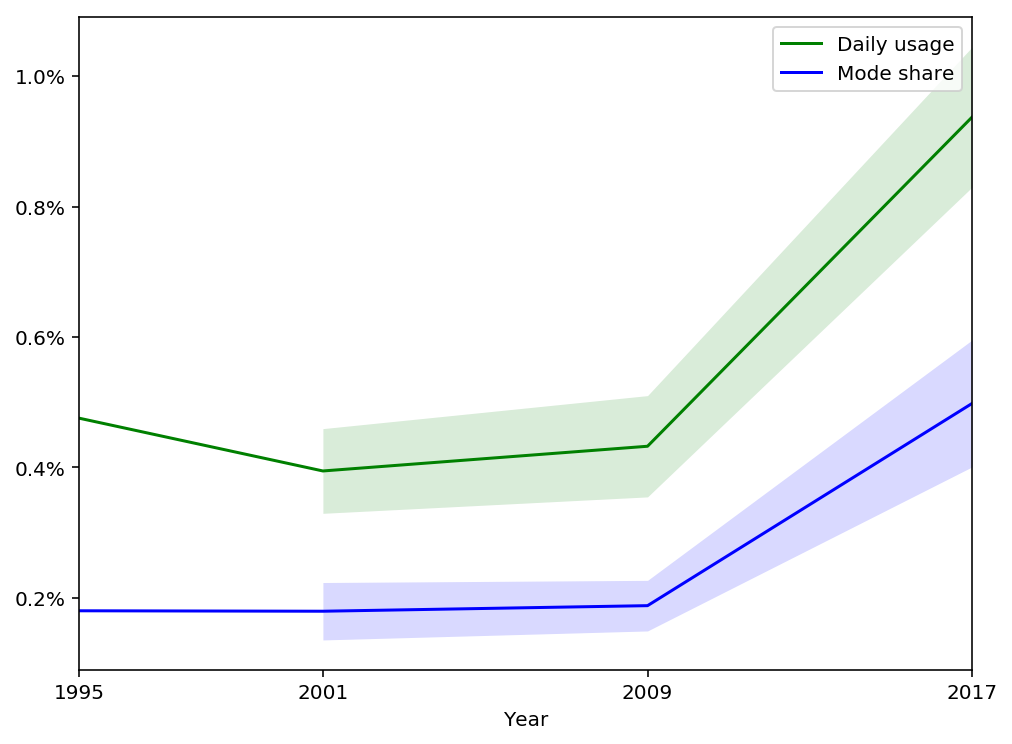

In [19]:
plt.figure(figsize=(8,6))
plt.fill_between(
    percent.index.values[1:], 
    (percent.proportion + 1.96 * percent.se).iloc[1:] * 100,
    (percent.proportion - 1.96 * percent.se).iloc[1:] * 100,
    color='green',
    alpha=0.15,
    lw=0
)
plt.plot(percent.index, percent.proportion * 100, color='green', label='Daily usage')
plt.xticks(percent.index)
plt.xlabel('Year')
plt.xlim(1995, 2017)
plt.yticks(np.arange(0.0, 1.2, 0.2), [f'{t:.1f}%' for t in np.arange(0.0, 1.2, 0.2)])

plt.fill_between(
    modeshare.index.values[1:], 
    (modeshare.proportion + 1.96 * modeshare.se).iloc[1:] * 100,
    (modeshare.proportion - 1.96 * modeshare.se).iloc[1:] * 100,
    color='blue',
    alpha=0.15,
    lw=0
)
plt.plot(modeshare.index, modeshare.proportion * 100, color='blue', label='Mode share')
plt.legend()
plt.savefig('../fig/growth_mode.pdf', bbox_inches='tight')


### Print out the results as tables

Because we want to quote a few precise results in the paper, we need to have the numbers.

In [20]:
modeshare['moe'] = modeshare.se * 1.96
(modeshare * 100).round(2)

,proportion,se,moe
1995,0.18,NaN,NaN
2001,0.18,0.02,0.04
2009,0.19,0.02,0.04
2017,0.50,0.05,0.10


In [21]:
percent['moe'] = percent.se * 1.96
(percent * 100).round(2)

,proportion,se,moe
1995,0.48,NaN,NaN
2001,0.39,0.03,0.06
2009,0.43,0.04,0.08
2017,0.94,0.05,0.11


## Modal exclusivity/multimodality

As mentioned above, we don't expect people who do use for-hire vehicles to use them a lot. This computes the exclusivity of a whole bunch of different modes to compare them. Unsurprisingly, driving is quite exclusive. Most drivers make all of their trips by driving. The same is not true of for-hire vehicles.

This is averaged over persons, I don't think we want heavier trip makers to weigh in more.

In [22]:
exclusivityTable = pd.DataFrame(
    columns=['est', 'se'],
    index=['For-hire vehicle', 'Auto', 'Transit', 'Walking', 'Biking', 'Active travel', 'Transit and walking'])

if True: # This takes a really long time to run, skip by default
    for mode, modeCodes in [
        ('For-hire vehicle', TAXI_MODE[2017]),
        ('Auto', [3, 4, 5, 6]),
        #('Transit', [11, 15, 16]),
        #('Walking', [1]),
        #('Biking', [2]),
        #('Biking and walking', [1, 2]),
        #('Transit and walking', [1, 11, 15, 16])
    ]:
        # The proportion of each person's trips that they took by the mode of interest
        # weight is constant for each person (trips do not have different weights), so no weights needed here
        persProp = trips17.groupby(['HOUSEID', 'PERSONID'], as_index=False).TRPTRANS\
            .agg(lambda x: np.sum(x.isin(modeCodes)) / np.sum(x >= 0) if np.sum(x >= 0) > 0 else 0)
        persProp = persProp[persProp.TRPTRANS > 0]
        persProp = persProp.merge(pers17, on=['HOUSEID', 'PERSONID'], how='left', validate='1:1')
        # Now take a weighted average
        propModeForModeUsers = np.average(persProp.TRPTRANS, weights=persProp.WTPERFIN / 1000) # avoid overflow
        propModeForModeUsers_se = estReplicateSE(
            lambda i: np.average(persProp.TRPTRANS, weights=persProp[f'WTPERFIN{i}'] / 1000),
            propModeForModeUsers,
            2017
        )

        exclusivityTable.loc[mode, 'est'] = propModeForModeUsers
        exclusivityTable.loc[mode, 'se'] = propModeForModeUsers_se
        
exclusivityTable['moe'] = exclusivityTable.se * 1.96
exclusivityTable * 100

,est,se,moe
For-hire vehicle,44.9958,1.44303,2.82833
Auto,92.6902,0.126449,0.247841
Transit,NaN,NaN,NaN
Walking,NaN,NaN,NaN
Biking,NaN,NaN,NaN
Active travel,NaN,NaN,NaN
Transit and walking,NaN,NaN,NaN


## Where do for-hire vehicle trips start and end

Is using the home location built environment characteristics appropriate?

In [23]:
taxiTrips = trips17[trips17.TRPTRANS.isin(TAXI_MODE[2017])]
# WHYTO/WHYFROM 1, 2 are home and work from home
homeTaxiTrips = taxiTrips[taxiTrips.WHYTO.isin([1, 2]) | taxiTrips.WHYFROM.isin([1, 2])]
print('FHV trips beginning/ending at home: ', computeValueAndSE(homeTaxiTrips, taxiTrips, 2017))

FHV trips beginning/ending at home:  $63.74\% \pm 10.42$


## Define a general purpose plotting function that plots trends

Plot the trend in percent of particular subsets of the population that used for hire vehicles on the travel day.

In [27]:
# Define a function that plots daily usage among subsets of the data
def plotBySubsets (subsets95, subsets01, subsets09, subsets17, colors=None, lineStyles=None, filename=None,
                   title=None, outlines=[], ax=None):
    columns = None
    # Create a data frame to store the usage percentages for each group in each year
    # First, figure out which years we're talking about
    years = []
    if subsets95 is not None:
        years.append(1995)
    if subsets01 is not None:
        years.append(2001)
    if subsets09 is not None:
        years.append(2009)
    if subsets17 is not None:
        years.append(2017)
    
    usageProp = pd.DataFrame(columns=columns, index=years)

    # . . . and one to store the standard errors
    usageSE = pd.DataFrame(columns=columns, index=years)

    for yr, dta, subsets in [
        (1995, pers95, subsets95),
        (2001, pers01, subsets01),
        (2009, pers09, subsets09),
        (2017, pers17, subsets17)
    ]:
        if subsets is None:
            continue # not plotting this year
            
        if columns is None:
            columns = list(subsets.keys())
        
        for subsetLabel in columns:
            usageProp.loc[yr, subsetLabel] =\
                np.sum(dta.loc[(subsets[subsetLabel]) & dta.taxi, WEIGHTS[yr]]) /\
                    np.sum(dta.loc[(subsets[subsetLabel]), WEIGHTS[yr]])

            if yr != 1995:
                usageSE.loc[yr, subsetLabel] = estReplicateSE(
                    lambda i: np.sum(dta.loc[(subsets[subsetLabel]) & dta.taxi, f'{REP_WEIGHTS[yr]}{i}']) /\
                        np.sum(dta.loc[(subsets[subsetLabel]), f'{REP_WEIGHTS[yr]}{i}']),
                    usageProp.loc[yr, subsetLabel],
                    yr
                )
            else:
                # no repl weights for 1995
                usageSE.loc[yr, subsetLabel] = np.nan

    usageProp *= 100
    usageSE *= 100
    usageMOE = usageSE * 1.96
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6.5))
    
    for subsetLabel in columns:
        est = usageProp.loc[:,subsetLabel].astype('float64')
        moe = usageMOE.loc[:,subsetLabel].astype('float64')
        lineStyle = lineStyles[subsetLabel] if lineStyles is not None else '-'
        generatedColorVals = {
            'r': ((pers17[subsets17[subsetLabel]].R_AGE.iloc[0] * 11) % 255) / 255,
            'g': ((pers17[subsets17[subsetLabel]].R_AGE.iloc[1] * 11) % 255) / 255,
            'b': ((pers17[subsets17[subsetLabel]].R_AGE.iloc[2] * 11) % 255) / 255
        }
        generatedColor = 'rgb({r},{g},{b})'.format(**generatedColorVals)
        color = colors[subsetLabel] if colors is not None else generatedColor
        if subsetLabel in outlines:
            plt.plot(usageProp.index, est - moe, color=color, ls='--', alpha=0.5, lw=1)
            plt.plot(usageProp.index, est + moe, color=color, ls='--', alpha=0.5, lw=1)
        else:
            plt.fill_between(usageProp.index, est - moe, est + moe, color=color, alpha=0.15, lw=0)
        plt.plot(usageProp.index, est, color=color, label=subsetLabel, ls=lineStyle)
        
        # labels on right
        wrappedLabel = textwrap.fill(subsetLabel, break_long_words=False, width=30)
        nLinesInLabel = wrappedLabel.count('\n') + 1
        plt.text(max(years) + 0.1, est.iloc[-1] - nLinesInLabel * 0.04, wrappedLabel)

    if title is not None:
        plt.title(title)
    plt.xlim((min(years), max(years)))
    plt.xticks(years)
    plt.ylabel('Percentage of people taking a\nfor-hire vehicle trip on any given day')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}%'))
        
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

## Income trends

We should deal with inflation as much as possible. The first cell computes what dollar value year in a given corresponds to the 2016 25k, 50k, and 100k cutpoints we use in the model.

In [24]:
cpi = pd.read_excel('../data/cpi.xlsx', skiprows=11).set_index('Year')

def getCpiInflationFactor (fromYear, toYear):
    fromCpi = cpi.loc[fromYear, 'Annual']
    toCpi = cpi.loc[toYear, 'Annual']
    return toCpi / fromCpi

def roundToNearest (sourceArray, targetArray):
    # https://stackoverflow.com/questions/2566412
    sourceArray = np.asarray(sourceArray)
    targetArray = np.asarray(targetArray)
    return np.vectorize(lambda x: targetArray[np.abs(x - targetArray).argmin()])(sourceArray)

# These breaks are used 1995-2009
breaks = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100]) * 1000

for year in [1995, 2001, 2009]:
    # - 1 because it's the previous year's income
    factor = getCpiInflationFactor(year - 1, 2016)
    targetCuts = np.array([25000, 50000, 100000]) / factor
    rounded = roundToNearest(targetCuts, breaks)
    print(f'For the {year} NHTS, target categories to match 2017 are {targetCuts.round(0)}')
    print(f'  Rounded to breaks: {rounded}')
    print(f'  Errors: {(rounded - targetCuts).round(0)}')

For the 1995 NHTS, target categories to match 2017 are [15437. 30874. 61748.]
  Rounded to breaks: [15000 30000 60000]
  Errors: [ -437.  -874. -1748.]
For the 2001 NHTS, target categories to match 2017 are [17937. 35874. 71748.]
  Rounded to breaks: [20000 35000 70000]
  Errors: [ 2063.  -874. -1748.]
For the 2009 NHTS, target categories to match 2017 are [22427. 44853. 89707.]
  Rounded to breaks: [20000 45000 80000]
  Errors: [-2427.   147. -9707.]


In [25]:
pers95['incomeCategory'] = pers95.HHFAMINC.replace({
    1: 'Less than $15,000',
    2: 'Less than $15,000',
    3: 'Less than $15,000',
    4: '$15,000--$29,999',
    5: '$15,000--$29,999',
    6: '$15,000--$29,999',
    7: '$30,000--$59,999',
    8: '$30,000--$59,999',
    9: '$30,000--$59,999',
    10: '$30,000--$59,999',
    11: '$30,000--$59,999',
    12: '$30,000--$59,999',
    13: '$60,000 or more',
    14: '$60,000 or more',
    15: '$60,000 or more',
    16: '$60,000 or more',
    17: '$60,000 or more',
    18: '$60,000 or more',
    98: np.nan,
    99: np.nan
}).astype('category').cat.reorder_categories([
    'Less than $15,000',
    '$15,000--$29,999',
    '$30,000--$59,999',
    '$60,000 or more'
])

pers01['incomeCategory'] = pers01.HHFAMINC.replace({
    -1: np.nan,
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than $20,000',
    2: 'Less than $20,000',
    3: 'Less than $20,000',
    4: 'Less than $20,000',
    5: '$20,000--$34,999',
    6: '$20,000--$34,999',
    7: '$20,000--$34,999',
    8: '$35,000--$69,999',
    9: '$35,000--$69,999',
    10: '$35,000--$69,999',
    11: '$35,000--$69,999',
    12: '$35,000--$69,999',
    13: '$35,000--$69,999',
    14: '$35,000--$69,999',
    15: '$70,000 or more',
    16: '$70,000 or more',
    17: '$70,000 or more',
    18: '$70,000 or more'
}).astype('category').cat.reorder_categories([
    'Less than $20,000',
    '$20,000--$34,999',
    '$35,000--$69,999',
    '$70,000 or more'
])

pers09['incomeCategory'] = pers09.HHFAMINC.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than $20,000',
    2: 'Less than $20,000',
    3: 'Less than $20,000',
    4: 'Less than $20,000',
    5: '$20,000--$44,999',
    6: '$20,000--$44,999',
    7: '$20,000--$44,999',
    8: '$20,000--$44,999',
    9: '$20,000--$44,999',
    10: '$45,000--$79,999',
    11: '$45,000--$79,999',
    12: '$45,000--$79,999',
    13: '$45,000--$79,999',
    14: '$45,000--$79,999',
    15: '$45,000--$79,999',
    16: '$45,000--$79,999',
    17: '$80,000 or more',
    18: '$80,000 or more',
}).astype('category').cat.reorder_categories([
    'Less than $20,000',
    '$20,000--$44,999',
    '$45,000--$79,999',
    '$80,000 or more'
])

pers17['incomeCategory'] = pers17.HHFAMINC\
    .replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than \$25,000',
    2: 'Less than \$25,000',
    3: 'Less than \$25,000',
    4: '\$25,000--\$49,999',
    5: '\$25,000--\$49,999',
    6: '\$50,000--\$99,999',
    7: '\$50,000--\$99,999',
    8: '\$100,000 or more',
    9: '\$100,000 or more',
    10: '\$100,000 or more',
    11: '\$100,000 or more'
})\
    .astype('category')\
    .cat\
    .reorder_categories([
        'Less than \$25,000',
        '\$25,000--\$49,999',
        '\$50,000--\$99,999',
        '\$100,000 or more'
    ])
    
    
trips17['incomeCategory'] = trips17.HHFAMINC\
    .replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than \$25,000',
    2: 'Less than \$25,000',
    3: 'Less than \$25,000',
    4: '\$25,000--\$49,999',
    5: '\$25,000--\$49,999',
    6: '\$50,000--\$99,999',
    7: '\$50,000--\$99,999',
    8: '\$100,000 or more',
    9: '\$100,000 or more',
    10: '\$100,000 or more',
    11: '\$100,000 or more'
})\
    .astype('category')\
    .cat\
    .reorder_categories([
        'Less than \$25,000',
        '\$25,000--\$49,999',
        '\$50,000--\$99,999',
        '\$100,000 or more'
    ])

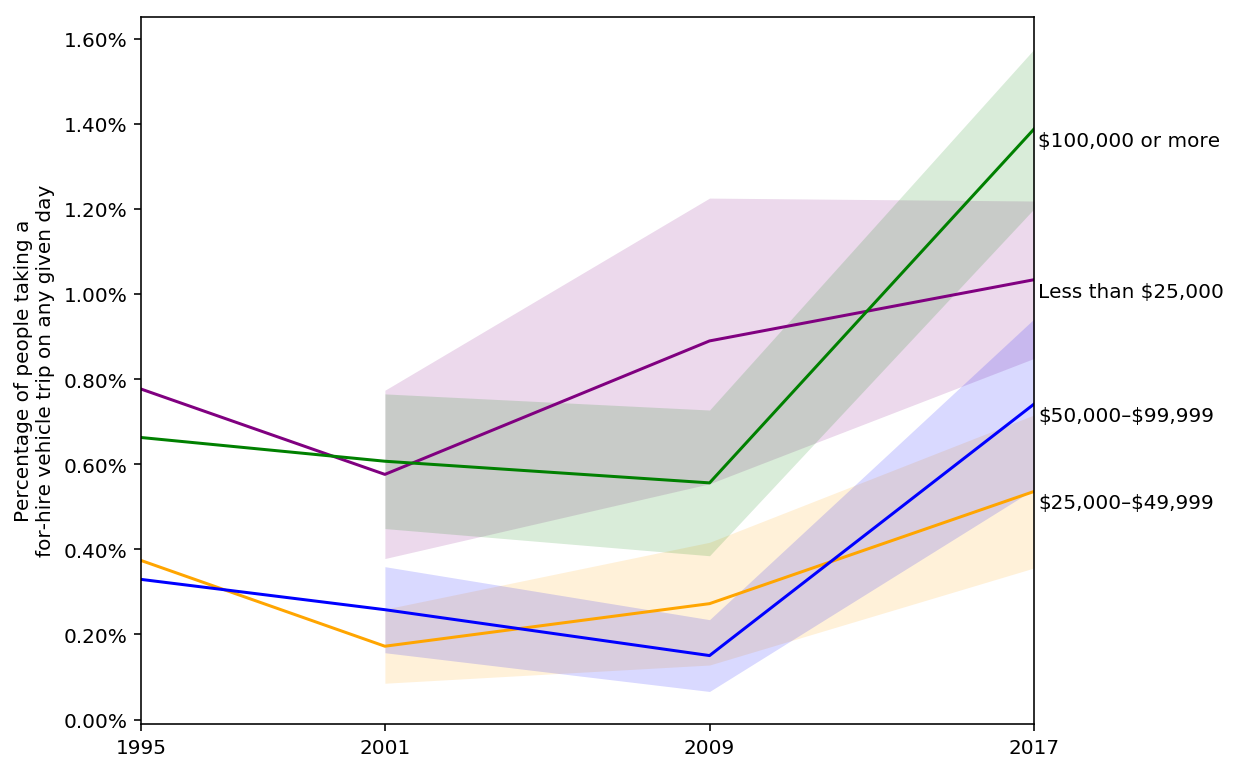

In [28]:
plotBySubsets(
    # not all years used the same income labels, due to CPI adjustment, but they use the same categories
    # in the same orders
    *[{
        'Less than \$25,000': dta.incomeCategory == dta.incomeCategory.cat.categories[0],
        '\$25,000–\$49,999': dta.incomeCategory == dta.incomeCategory.cat.categories[1],
        '\$50,000–\$99,999': dta.incomeCategory == dta.incomeCategory.cat.categories[2],
        '\$100,000 or more': dta.incomeCategory == dta.incomeCategory.cat.categories[3]
    } for dta in [pers95, pers01, pers09, pers17]],
    colors={
        'Less than \$25,000': 'purple',
        '\$25,000–\$49,999': 'orange',
        '\$50,000–\$99,999': 'blue',
        '\$100,000 or more': 'green'
    },
    filename='../fig/income_trends.pdf'
)

## Geographic trends

Ridehailing has expanded the geographic reach of for-hire vehicles beyond their former bastions in a few large cities (sometime, ask me about my experience getting a cab in Macon, Georgia before ridehailing existed). Quantify these trends.

In [29]:
# Helpfully, the NHTS has used almost the same MSA size codes since 1995, with the only exception being that some
# years have "Not in MSA" as 6, and some have it as 94.

for dta in [pers95, pers01, pers09, pers17, trips95, trips01, trips09, trips17]:
        dta['msaSize'] = dta.MSASIZE.replace({
            -9: np.nan, # There are 2 NANs in 2009. I don't know how that happened but it did.
            94: 'Not in MSA', # 1995
            6: 'Not in MSA', # 2001-2017
            1: 'Less than 250,000',
            2: '250,000 to 499,999',
            3: '500,000 to 999,999',
            4: '1,000,000 to 2,999,999',
            5: 'More than 3 million'
        }).astype('category').cat.reorder_categories([
            'Not in MSA',
            'Less than 250,000',
            '250,000 to 499,999',
            '500,000 to 999,999',
            '1,000,000 to 2,999,999',
            'More than 3 million'
        ])

pass # supress printing

### Look at proportions of for-hire vehicle users in the New York metro area

Taxicabs are an iconic feature of New York. What percentage of for-hire vehicle users were there across the waves of the NHTS?

Matt Coogan at the NHTS conference suggested that the complement of this graph might make more sense, showing an increase outside NYC. He might be right, if we were to present this graph in future presentations. This figure is not in the paper.

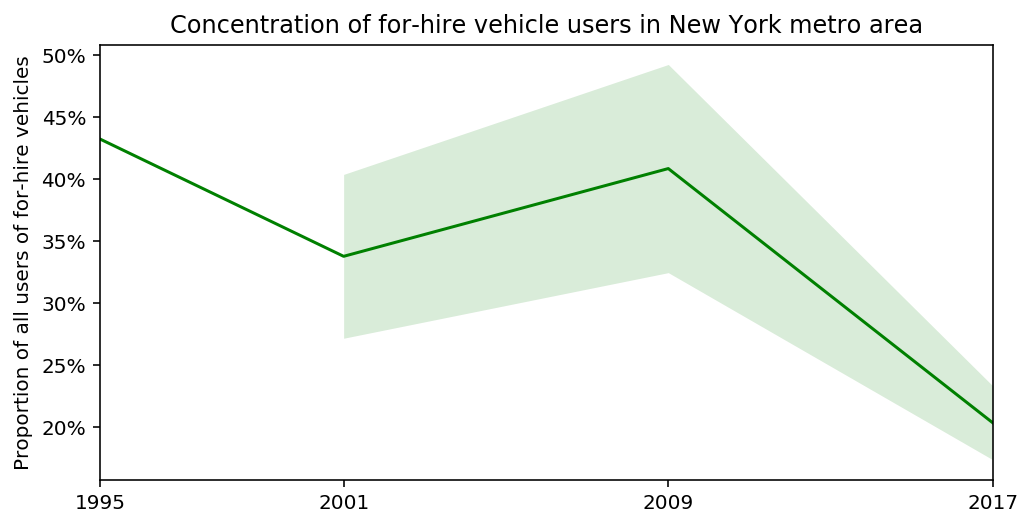

In [30]:
NYC = {
    2017: ('HH_CBSA', '35620'),
    2009: ('HH_CBSA', '35620'),
    2001: ('HHC_MSA', '5602'),
    1995: ('HHCMSA', 5602)
}

proportionUsersNYC =\
    pd.DataFrame(dict(est=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])
    
for year, dta in ((2017, pers17), (2009, pers09), (2001, pers01), (1995, pers95)):
    cbsaCol, cbsa = NYC[year]
    proportionUsersNYC.loc[year, 'est'] =\
        np.sum(dta.loc[dta.taxi & (dta[cbsaCol] == cbsa), WEIGHTS[year]]) /\
        np.sum(dta.loc[dta.taxi, WEIGHTS[year]])
    proportionUsersNYC.loc[year, 'se'] = np.nan if year == 1995 else estReplicateSE(
        lambda i: np.sum(dta.loc[dta.taxi & (dta[cbsaCol] == cbsa), f'{REP_WEIGHTS[year]}{i}']) /\
            np.sum(dta.loc[dta.taxi, f'{REP_WEIGHTS[year]}{i}']),
        proportionUsersNYC.loc[year, 'est'],
        year=year
    )

plt.figure(figsize=(8, 4))

plt.title('Concentration of for-hire vehicle users in New York metro area')
plt.ylabel('Proportion of all users of for-hire vehicles')

proportionUsersNYC *= 100
plt.fill_between(
    proportionUsersNYC.index,
    proportionUsersNYC.est - proportionUsersNYC.se * 1.96,
    proportionUsersNYC.est + proportionUsersNYC.se * 1.96,
    color='green',
    alpha=0.15,
    lw=0
)
plt.plot(proportionUsersNYC.index, proportionUsersNYC.est, color='green', label='New York City metro area')

plt.xticks([1995, 2001, 2009, 2017])
plt.xlim(1995, 2017)
plt.yticks(np.arange(20, 55, 5), [f'{i:d}%' for i in range(20, 55, 5)])

plt.savefig('../fig/geogconcentration_nyc.pdf', bbox_inches='tight')

## Print out numerical results for quoting in the paper

Print out the percentage of users in NY, the NE, MSAs over 3 million, and MSAs under 1 million, respectively. Note that these are in raw percentages, not proportions.

In [32]:
proportionUsersNYC['moe'] = proportionUsersNYC['se'] * 1.96
proportionUsersNYC.round(2)

,est,se,moe
1995,43.22,NaN,NaN
2001,33.77,3.37,6.60
2009,40.84,4.28,8.39
2017,20.35,1.52,2.97


## Look at usage by metro area size

Metros outside New York have pretty large error bars (except, probably, the metros that were add-on areas). Pool them by metro area size. This is Figure 2 in the paper.

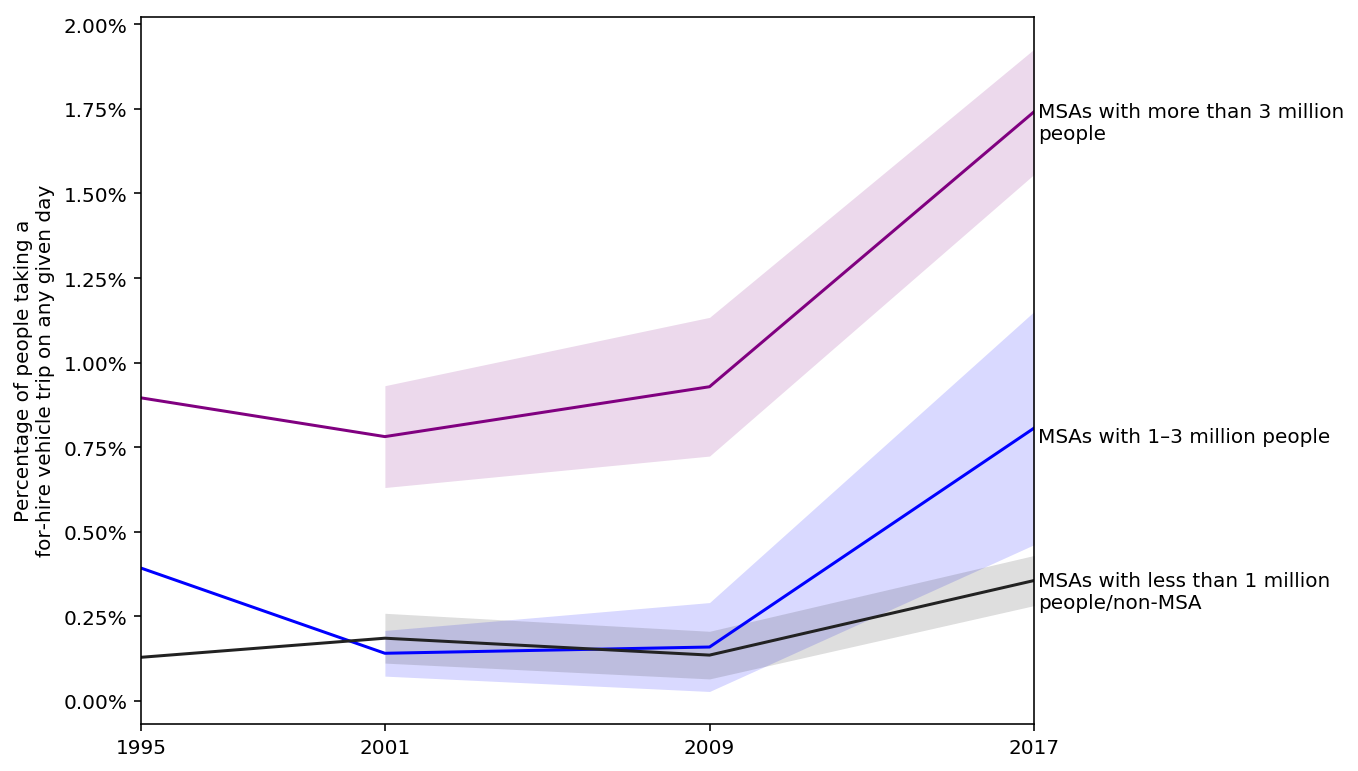

In [52]:
subsets95Gen = {}
subsets01Gen = {}
subsets09Gen = {}
subsets17Gen = {}

for year, dta, subsetsGen in [
    (1995, pers95, subsets95Gen),
    (2001, pers01, subsets01Gen),
    (2009, pers09, subsets09Gen),
    (2017, pers17, subsets17Gen)
]:
    subsetsGen['MSAs with more than 3 million people'] = (dta.msaSize == 'More than 3 million')
    subsetsGen['MSAs with 1–3 million people'] = (dta.msaSize == '1,000,000 to 2,999,999')
    subsetsGen['MSAs with less than 1 million people/non-MSA'] =\
        dta.msaSize.isin(['Not in MSA', 'Less than 250,000', '250,000 to 499,999', '500,000 to 999,999'])
    
plotBySubsets(subsets95Gen, subsets01Gen, subsets09Gen, subsets17Gen, colors = {
    'MSAs with less than 1 million people/non-MSA': '#222222',
    'MSAs with 1–3 million people': 'blue',
    'MSAs with more than 3 million people': 'purple'
},
              filename='../fig/geogusage_size.pdf')

#### Same figure, excluding those who are out of town

Make the same plot, excluding people who are out of town and presumably less affected by their built environment. Note that it is basically identical. This figure is not in the paper.

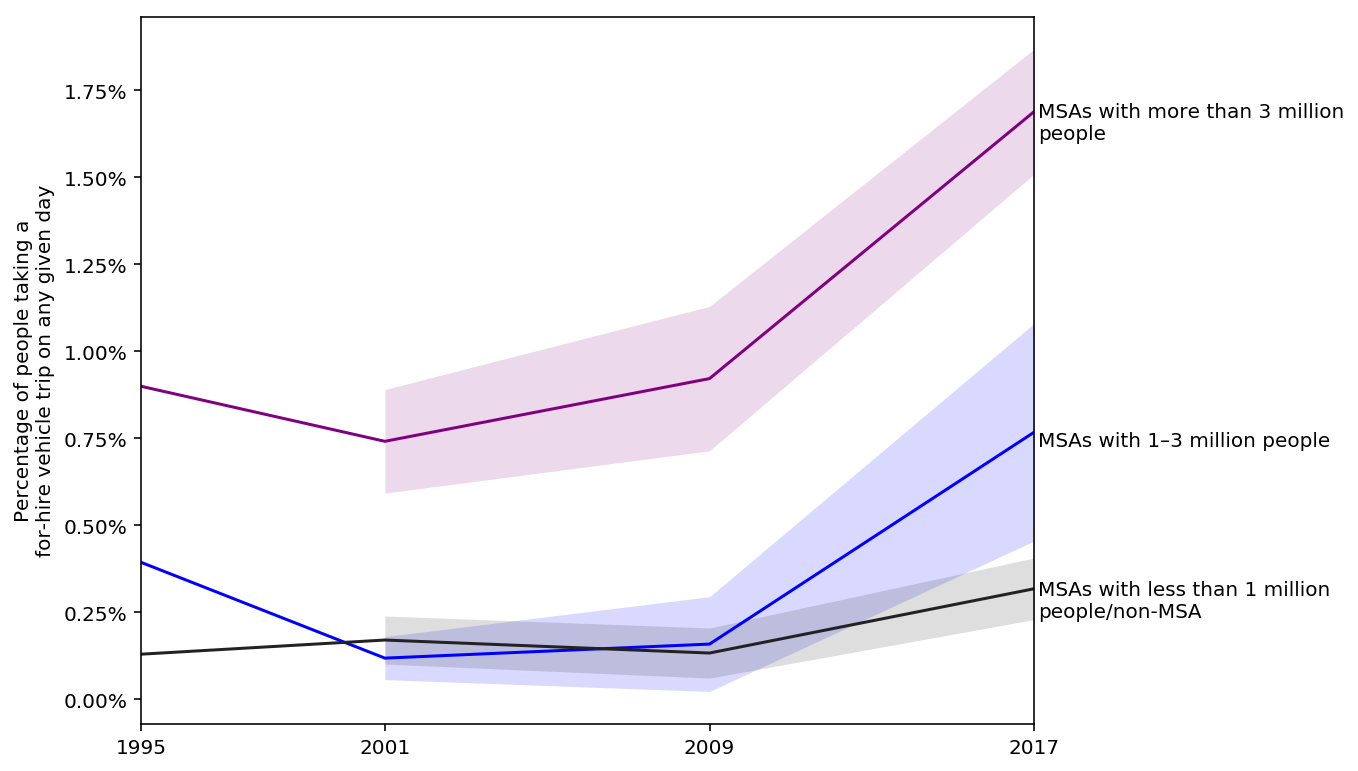

In [37]:
subsets95Gen = {}
subsets01Gen = {}
subsets09Gen = {}
subsets17Gen = {}

for year, dta, subsetsGen in [
    (1995, pers95, subsets95Gen),
    (2001, pers01, subsets01Gen),
    (2009, pers09, subsets09Gen),
    (2017, pers17, subsets17Gen)
]:
    inTown = dta.OUTCNTRY != 1 if year == 1995 else dta.OUTOFTWN != 1
    subsetsGen['MSAs with more than 3 million people'] = (dta.msaSize == 'More than 3 million') & inTown
    subsetsGen['MSAs with 1–3 million people'] = (dta.msaSize == '1,000,000 to 2,999,999') & inTown
    subsetsGen['MSAs with less than 1 million people/non-MSA'] =\
        dta.msaSize.isin(['Not in MSA', 'Less than 250,000', '250,000 to 499,999', '500,000 to 999,999']) & inTown
    
plotBySubsets(subsets95Gen, subsets01Gen, subsets09Gen, subsets17Gen, colors = {
    'MSAs with less than 1 million people/non-MSA': '#222222',
    'MSAs with 1–3 million people': 'blue',
    'MSAs with more than 3 million people': 'purple'
})

### Break it down to individual cities

These will have huge error bars, but are useful to show how trends differ in cities that had robust taxi markets (NYC, Boston) or banned ridehailing (Philly) as opposed to those that didn't (DC, San Francisco, Chicago). These figures are not in the paper.

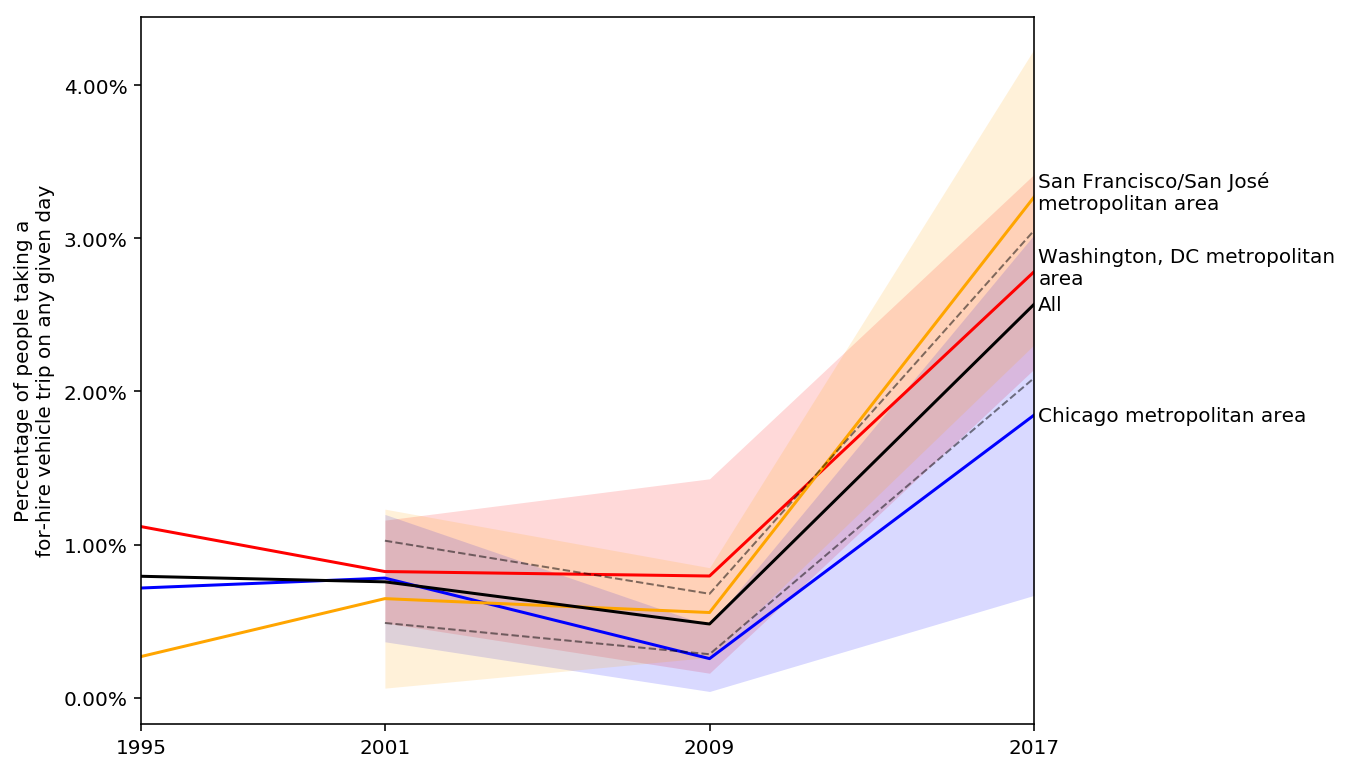

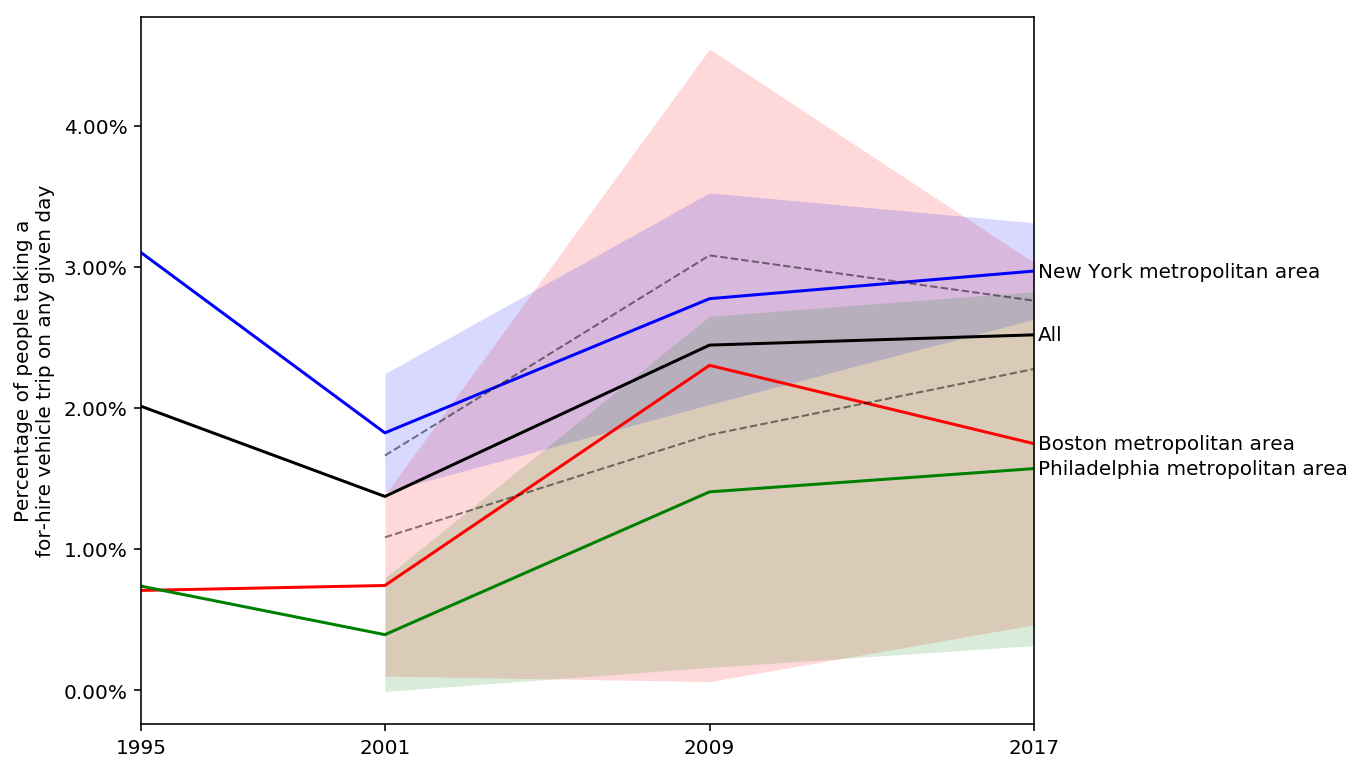

In [53]:
citiesByYear = {
    2017: {
        'BOS': ('HH_CBSA', '14460'),
        'DCA': ('HH_CBSA', '47900'),
        'ORD': ('HH_CBSA', '16980'),
        'JFK': ('HH_CBSA', '35620'),
        'SFO': ('HH_CBSA', ['41860', '41940']), # San Francisco and San José really function as a single metro
        'PHL': ('HH_CBSA', '37980')
    },
    2009: {
        'BOS': ('HH_CBSA', '14460'),
        'DCA': ('HH_CBSA', '47900'),
        'ORD': ('HH_CBSA', '16980'),
        'JFK': ('HH_CBSA', '35620'),
        'SFO': ('HH_CBSA', ['41860', '41940']),
        'PHL': ('HH_CBSA', '37980')
    },
    2001: {
        'BOS': ('HHC_MSA', '1122'),
        'DCA': ('HHC_MSA', '8872'),
        'ORD': ('HHC_MSA', '1602'),
        'JFK': ('HHC_MSA', '5602'),
        'SFO': ('HHC_MSA', '7362'), # San Francisco and San José were together in 2001
        'PHL': ('HHC_MSA', '6162')
    },
    1995: {
        'BOS': ('HHMSA', 1123),
        'DCA': ('HHCMSA', 8872),
        'ORD': ('HHCMSA', 1602),
        'JFK': ('HHCMSA', 5602),
        'SFO': ('HHCMSA', 7362),
        'PHL': ('HHCMSA', 6162)
    }
}

cityNames = {
    'BOS': 'Boston metropolitan area',
    'DCA': 'Washington, DC metropolitan area',
    'ORD': 'Chicago metropolitan area',
    'JFK': 'New York metropolitan area',
    'SFO': 'San Francisco/San José metropolitan area',
    'PHL': 'Philadelphia metropolitan area'
}

subsets95 = {0: {}, 1: {}}
subsets01 = {0: {}, 1: {}}
subsets09 = {0: {}, 1: {}}
subsets17 = {0: {}, 1: {}}

plot1 = ['PHL', 'BOS', 'JFK']

for year, dta, subsets in [
    (1995, pers95, subsets95),
    (2001, pers01, subsets01),
    (2009, pers09, subsets09),
    (2017, pers17, subsets17)
]:
    for city, criterion in citiesByYear[year].items():
        if isinstance(criterion[1], list):
            subset = dta[criterion[0]].isin(criterion[1])
        else:
            subset = dta[criterion[0]] == criterion[1]
        
        if city in plot1:
            subsets[1][cityNames[city]] = subset
        else:
            subsets[0][cityNames[city]] = subset
            
    # Make a composite category in each set of subsets
    for plot in [0, 1]:
        subsetLabels = list(subsets[plot].keys())
        composite = subsets[plot][subsetLabels[0]].copy()
        for key in subsetLabels[1:]:
            composite |= subsets[plot][key]
        subsets[plot]['All'] = composite

# Cities that have seen significant growth in ridehailing usage
# Also the chart of cities where Matt's lived, coincidentally (or not?)
plotBySubsets(subsets95[0], subsets01[0], subsets09[0], subsets17[0], colors={
    'Chicago metropolitan area': 'blue', # Go Cubs!
    'Washington, DC metropolitan area': 'red', # Go Nats!
    'San Francisco/San José metropolitan area': 'orange', # Go Giants!
    'All': 'black'
}, outlines=['All'], filename='../fig/cityincreases.pdf')

plotBySubsets(subsets95[1], subsets01[1], subsets09[1], subsets17[1], colors={
    'New York metropolitan area': 'blue', # Go Yankees!
    'Boston metropolitan area': 'red', # Go Sox!
    'Philadelphia metropolitan area': 'green', # Go Eagles!
    'All': 'black'
}, outlines=['All'], filename='../fig/cityflat.pdf')

## Do people use for-hire vehicles a lot more when they are out of town?

### What percentage of FHV trips are taken by people who are out of town?

And what percentage of people are out of town at any given time?

In [41]:
# Add out of town variable to trips file
trips17 = trips17.merge(
    pers17[['HOUSEID', 'PERSONID', 'OUTOFTWN']],
    on=('HOUSEID', 'PERSONID'),
    validate='m:1',
    how='left'
)

In [42]:
# No missing data for OUTOFTWN in 2017
outOfTownTaxiProp = np.sum(trips17.loc[(trips17.OUTOFTWN == 1) & trips17.TRPTRANS.isin(TAXI_MODE[2017]), WEIGHTS[2017]]) /\
    np.sum(trips17.loc[trips17.TRPTRANS.isin(TAXI_MODE[2017]), WEIGHTS[2017]])
    
outOfTownTaxiSE = estReplicateSE(
    lambda i:\
        np.sum(trips17.loc[(trips17.OUTOFTWN == 1) & trips17.TRPTRANS.isin(TAXI_MODE[2017]), f'{REP_WEIGHTS[2017]}{i}']) /\
        np.sum(trips17.loc[trips17.TRPTRANS.isin(TAXI_MODE[2017]), f'{REP_WEIGHTS[2017]}{i}']),
    outOfTownTaxiProp,
    2017
)

outOfTownProp = np.sum(trips17.loc[(trips17.OUTOFTWN == 1), WEIGHTS[2017]]) /\
    np.sum(trips17[WEIGHTS[2017]])
    
outOfTownSE = estReplicateSE(
    lambda i:\
        np.sum(trips17.loc[(trips17.OUTOFTWN == 1), f'{REP_WEIGHTS[2017]}{i}']) /\
        np.sum(trips17[f'{REP_WEIGHTS[2017]}{i}']),
    outOfTownProp,
    2017
)

print(f'{outOfTownTaxiProp * 100:.2f} +/- {outOfTownTaxiSE * 100 * 1.96:.2f} of FHV trips are taken by people who are out of town')
print(f'{outOfTownProp * 100:.2f} +/- {outOfTownSE * 100 * 1.96:.2f} of all trips are taken by people who are out of town')

8.31 +/- 2.42 of FHV trips are taken by people who are out of town
2.50 +/- 0.15 of all trips are taken by people who are out of town


## Age of for-hire vehicle users

Ridehailing is heavily used by young people. How true is that of the overall for-hire vehicle market over the years?

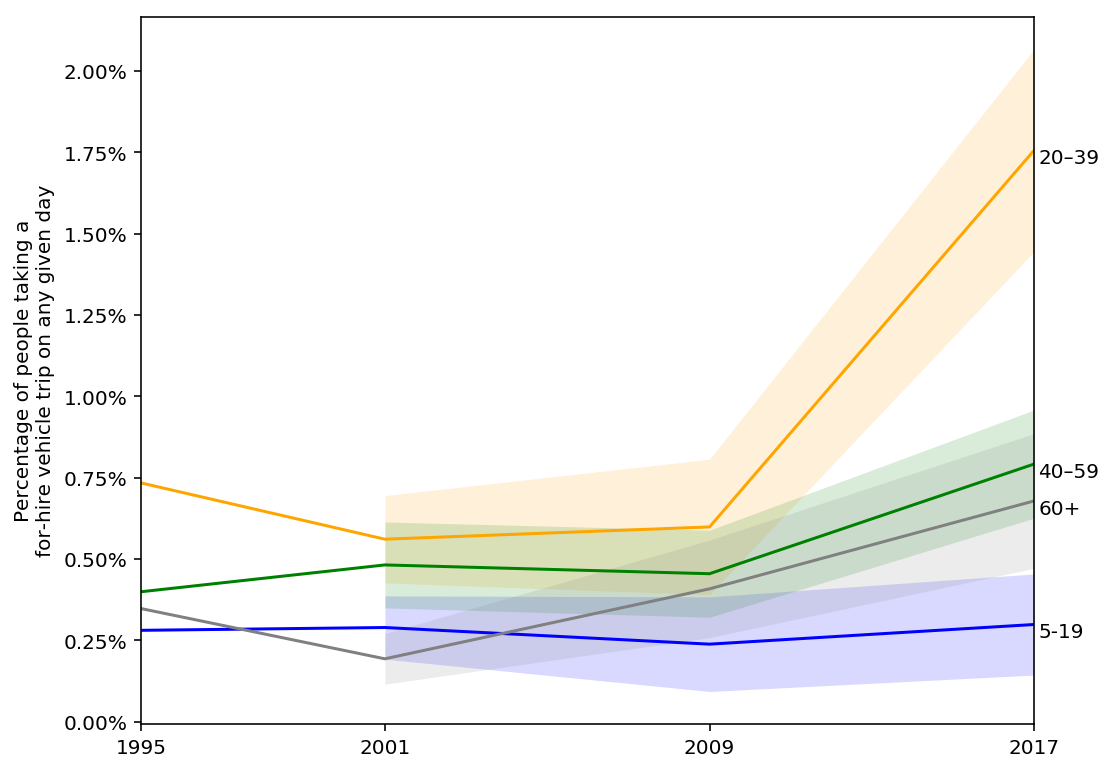

In [45]:
plotBySubsets(*[
    {
        '5-19': (dta.R_AGE < 20) & (dta.R_AGE >= 5),
        '20–39': (dta.R_AGE >= 20) & (dta.R_AGE < 40),
        '40–59': (dta.R_AGE >= 40) & (dta.R_AGE < 60),
        '60+': dta.R_AGE > 60
    } for dta in (pers95, pers01, pers09, pers17)],
    colors={
        '5-19': 'blue',
        '20–39': 'orange',
        '40–59': 'green',
        '60+': 'gray'
    },
    filename='../fig/agetrend.pdf'
)